### Project: Analyze fluctuations in HTTP request latency data to determine reliability

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.options.mode.chained_assignment = None

In [2]:
FIG_SIZE = (20, 4)

In [3]:
# Load dataset from CSV file
# Source: https://gr.itim.vn/explore?orgId=1&left=%7B%22datasource%22:%22FDX2yy2Vz%22,%22queries%22:%5B%7B%22refId%22:%22A%22,%22datasource%22:%7B%22type%22:%22prometheus%22,%22uid%22:%22FDX2yy2Vz%22%7D,%22editorMode%22:%22code%22,%22expr%22:%22histogram_quantile%280.95,%20sum%28rate%28nginx_ingress_controller_response_duration_seconds_bucket%7Bapp%3D%5C%22ingress-nginx%5C%22,%20%20ingress%3D%5C%22accounts-api%5C%22,%20host%3D%5C%22accounts-api.coccoc.com%5C%22%7D%5B5m%5D%29%29%20by%20%28le%29%29%22,%22legendFormat%22:%22__auto%22,%22range%22:true,%22instant%22:false,%22format%22:%22time_series%22,%22interval%22:%225m%22,%22hide%22:true%7D,%7B%22refId%22:%22B%22,%22datasource%22:%7B%22type%22:%22prometheus%22,%22uid%22:%22FDX2yy2Vz%22%7D,%22editorMode%22:%22code%22,%22expr%22:%22sum%28rate%28nginx_ingress_controller_response_duration_seconds_bucket%7Bapp%3D%5C%22ingress-nginx%5C%22,%20%20ingress%3D%5C%22accounts-api%5C%22,%20host%3D%5C%22accounts-api.coccoc.com%5C%22%7D%5B5m%5D%29%29%20by%20%28le%29%22,%22legendFormat%22:%22__auto%22,%22range%22:true,%22instant%22:false,%22format%22:%22time_series%22,%22hide%22:true%7D,%7B%22refId%22:%22C%22,%22datasource%22:%7B%22type%22:%22prometheus%22,%22uid%22:%22FDX2yy2Vz%22%7D,%22editorMode%22:%22code%22,%22expr%22:%22nginx_ingress_controller_response_duration_seconds_bucket%7Bapp%3D%5C%22ingress-nginx%5C%22,%20%20ingress%3D%5C%22accounts-api%5C%22,%20host%3D%5C%22accounts-api.coccoc.com%5C%22%7D%22,%22legendFormat%22:%22__auto%22,%22range%22:true,%22instant%22:false,%22format%22:%22table%22,%22hide%22:false%7D%5D,%22range%22:%7B%22from%22:%221710111600000%22,%22to%22:%221710115200000%22%7D%7D
root_df = pd.read_csv('../statics/csv/Explore-data-2024-03-11 16_31_53.csv')

In [4]:
# Clean data
# Select related columns
cols = root_df.columns.to_list()
colums_drop = []
for col in cols:
    num_row = root_df.drop_duplicates(subset=col).__len__()
    if num_row == 1:
        colums_drop.append(col)
root_df = root_df.drop(columns=colums_drop) # Only select column selected
# Rename columns
cols_rename_dict = {
    "Time": "timestamp",
    "Value": "value"
}
root_df = root_df.rename(columns=cols_rename_dict)
# Change datetime format for column "timestamp" and timezone
root_df['timestamp'] = pd.to_datetime(root_df["timestamp"], unit="ms", utc=True).map(lambda x: x.tz_convert('Asia/Ho_Chi_Minh'))

# Hash value from column kubernetes_node because issue about privacy
root_df.head()

,timestamp,controller_pod,instance,kubernetes_node,kubernetes_pod_name,le,method,status,value
0,2024-03-11 06:00:00+07:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,inf,DELETE,404,175
1,2024-03-11 06:00:30+07:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,inf,DELETE,404,175
2,2024-03-11 06:01:00+07:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,inf,DELETE,404,175
3,2024-03-11 06:01:30+07:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,inf,DELETE,404,175
4,2024-03-11 06:02:00+07:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,inf,DELETE,404,175


In [5]:
# Get all group (maybe call legends) in dataset
legend_labels = root_df.columns.drop(['timestamp', 'value']).to_list()
legends = root_df.groupby(legend_labels).first().reset_index()[legend_labels]

In [6]:
# Simulator rate by freq
FREQ_RATE = "5min"

arr_df_rate = []
for idx, el in legends.iterrows():
    # Buile query
    query_string = ""
    for idx, label in enumerate(legend_labels):
        if label not in ["le", "status"]:
            query_string += f"{label} == '{el[label]}' "
        else:
            query_string += f"{label} == {el[label]} "
        if idx != len(legend_labels) - 1:
            query_string += "and "
    sample = root_df.query(query_string).groupby([pd.Grouper(key="timestamp", freq=FREQ_RATE)])[legend_labels + ["value"]].first()
    # Calculate rate()
    sample['rate'] = sample['value'].diff(
    ) / sample.index.to_series().diff().dt.total_seconds()
    arr_df_rate.append(sample)
df_rate_freq = pd.concat(arr_df_rate)
# Drop first row having NaN value in rate
df_rate_freq = df_rate_freq.dropna()


In [7]:
df_rate_freq.head()

,controller_pod,instance,kubernetes_node,kubernetes_pod_name,le,method,status,value,rate
timestamp,,,,,,,,,
2024-03-11 06:05:00+07:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,0.005,DELETE,404,0,0.0
2024-03-11 06:10:00+07:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,0.005,DELETE,404,0,0.0
2024-03-11 06:15:00+07:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,0.005,DELETE,404,0,0.0
2024-03-11 06:20:00+07:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,0.005,DELETE,404,0,0.0
2024-03-11 06:25:00+07:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,0.005,DELETE,404,0,0.0


### CALCULATE SUM(RATE)

In [8]:
df_sum_rate = pd.DataFrame()
df_sum_rate['rate'] = df_rate_freq.groupby(['timestamp', 'le'])['rate'].sum()
df_sum_rate.reset_index(inplace=True)

In [9]:
increase_rate_buckets = df_sum_rate.pivot(index="timestamp", columns="le", values="rate").reset_index().rename_axis(None, axis=1)

In [10]:
increase_rate_buckets

,timestamp,0.005,0.01,0.025,0.05,0.1,0.25,0.5,1.0,2.5,5.0,10.0,inf
0,2024-03-11 06:05:00+07:00,0.000000,0.000000,10.630000,21.230000,23.200000,23.280000,23.286667,23.286667,23.286667,23.286667,23.286667,23.286667
1,2024-03-11 06:10:00+07:00,0.073333,0.076667,10.596667,21.926667,23.996667,24.083333,24.083333,24.083333,24.083333,24.083333,24.083333,24.083333
2,2024-03-11 06:15:00+07:00,0.226667,0.236667,11.220000,23.090000,25.313333,25.416667,25.420000,25.420000,25.420000,25.420000,25.420000,25.420000
3,2024-03-11 06:20:00+07:00,0.176667,0.180000,12.030000,23.526667,25.593333,25.676667,25.686667,25.690000,25.690000,25.690000,25.690000,25.690000
4,2024-03-11 06:25:00+07:00,0.173333,0.180000,11.580000,23.526667,25.813333,25.920000,25.933333,25.933333,25.933333,25.933333,25.933333,25.933333
5,2024-03-11 06:30:00+07:00,0.446667,0.490000,13.373333,25.750000,28.030000,28.130000,28.136667,28.136667,28.136667,28.136667,28.136667,28.136667
6,2024-03-11 06:35:00+07:00,0.166667,0.176667,11.523333,23.973333,26.256667,26.360000,26.373333,26.373333,26.373333,26.373333,26.373333,26.373333
7,2024-03-11 06:40:00+07:00,0.160000,0.166667,11.640000,24.280000,26.603333,26.686667,26.696667,26.696667,26.696667,26.696667,26.696667,26.696667
8,2024-03-11 06:45:00+07:00,0.193333,0.200000,12.030000,25.266667,27.343333,27.426667,27.436667,27.436667,27.436667,27.436667,27.436667,27.436667
9,2024-03-11 06:50:00+07:00,0.153333,0.160000,13.700000,25.426667,27.430000,27.526667,27.543333,27.546667,27.546667,27.546667,27.546667,27.546667


### CALCULATE HISTOGRAM_PERCENTILE

,timestamp,0.95
0,2024-03-11 06:05:00+07:00,0.072648
1,2024-03-11 06:10:00+07:00,0.073007
2,2024-03-11 06:15:00+07:00,0.073816
3,2024-03-11 06:20:00+07:00,0.071262
4,2024-03-11 06:25:00+07:00,0.074271
5,2024-03-11 06:30:00+07:00,0.071488
6,2024-03-11 06:35:00+07:00,0.073679
7,2024-03-11 06:40:00+07:00,0.073282
8,2024-03-11 06:45:00+07:00,0.069217
9,2024-03-11 06:50:00+07:00,0.068536


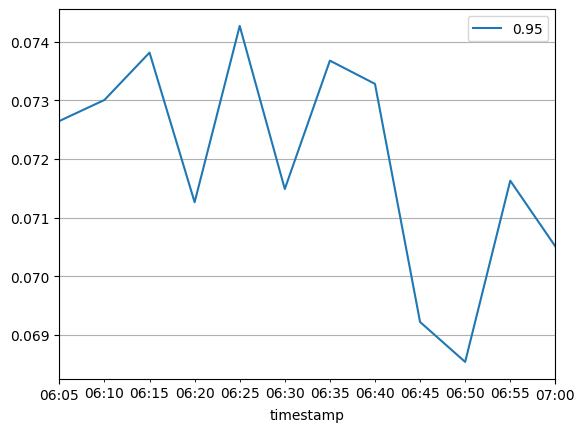

In [11]:
def histogram_percentile(percentiles: float, row: pd.Series):
    count = row[np.Inf]
    rank = count * percentiles
    row_diff = row.diff()
    row_diff.loc[0.005] = row[0.005]
    row_diff.fillna(0, inplace=True)
    count, upper, lower = 0, 0, 0
    stack = []
    for bucket, val in row_diff.items():
        count = count + val
        el = dict(
            bucket=bucket,
            rate=count
        )
        if len(stack) == 0:
            # Add first value
            stack.append(el)
            lower, upper = el, el
            continue
        lower = stack[-1]
        upper = el
        stack.append(el)
        if count >= rank:
            break
    # Using Linear interpolation
    y0, y1 = lower['bucket'], upper['bucket']
    x0, x1 = lower['rate'], upper['rate']
    x = rank
    return (((y1-y0)*(x - x0)) / (x1 - x0)) + y0

percentile = 0.95
result = increase_rate_buckets.set_index('timestamp').apply(lambda x: histogram_percentile(
    percentiles=percentile, row=x), axis=1)
result = result.to_frame(name=percentile).reset_index()
result.plot(grid=True, x="timestamp", y=0.95)
result